#### Resources
[Paper on CA FWI](https://cfs.nrcan.gc.ca/pubwarehouse/pdfs/31168.pdf)

[National Wildfire Coordinating Group](https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-fwi-system)

[Map of Montesinho Natural Park](https://www.researchgate.net/figure/Map-of-the-Montesinho-Natural-Park-Portugal_fig1_325092904)

In [1]:
# Standard Data Science/Analysis Toolkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns

# Machine Learning Tools, Utilities, and Scoring Metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

Access our data set. We found this from [kaggle](https://www.kaggle.com/datasets/elikplim/forest-fires-data-set/data)

In [2]:
df = pd.read_csv('data/forestfires.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


Looks like no null values, but we will have to check later if there are non-null values that are skewing data.

In [3]:
df.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0


In [4]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
dec      9
apr      9
jan      2
may      2
nov      1
Name: month, dtype: int64

We don't have consistent time data here, does that matter?

### Let's do some research

ISI, FFMC, DMC, DC are all values determined by the four factors of Temp, RH(relative humidity), wind, and rain. So let's focus on those four instead of the values that are created. Following some research, I found that those combined values require consistent daily data to determine and we don't have that in this data set. Also, BUI and FWI are determined even further.

In [5]:
cols = list(df.columns.values)


RH (Relative Humidity), Temperature, Rain, and Wind are all used to calculate FFMC, DMC, DC with Wind being a unit required to determine ISI. So let's drop those three values since they aren't needed. 

In [6]:
# df_cleaned = df.drop(['FFMC', 'DMC', 'DC', 'ISI'], axis=1)
df_cleaned = df

In [7]:
df_cleaned.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Let's check out the features with 0 as a min. 

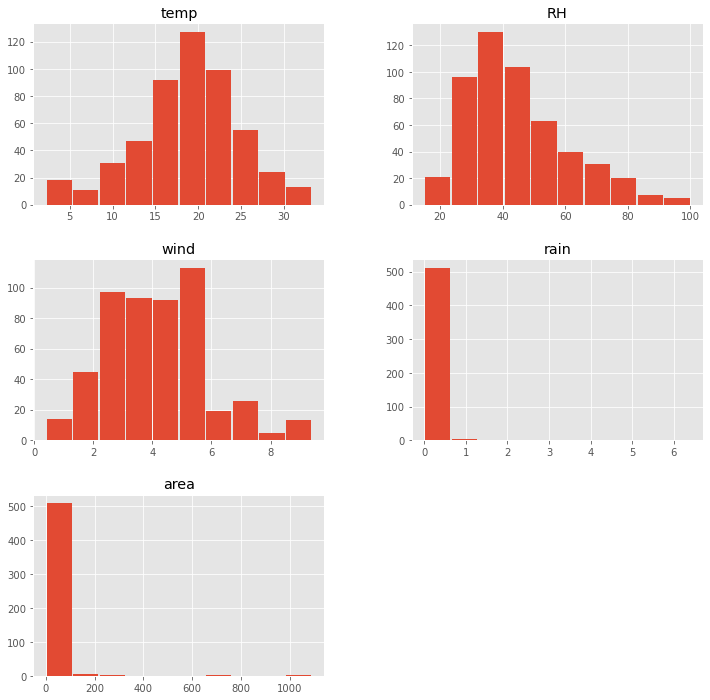

In [8]:
df_cleaned[['temp', 'RH', 'wind', 'rain', 'area']].hist(rwidth=0.95, figsize=(12,12))
plt.show()

In [9]:
df_cleaned.rain.value_counts()

0.0    509
0.8      2
0.2      2
0.4      1
6.4      1
1.4      1
1.0      1
Name: rain, dtype: int64

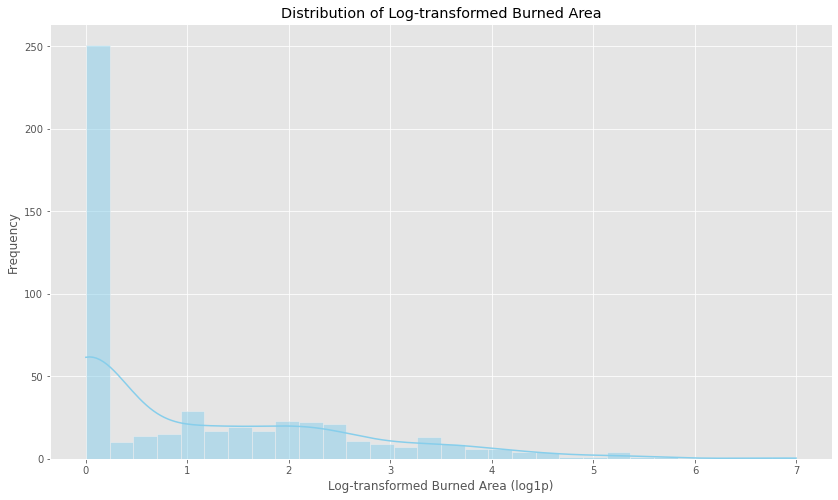

In [10]:
# np.log1p is used instead of np.log to handle zero values gracefully. log1p(x) computes log(1 + x), which is more stable for small values.

df_cleaned['log_burned_area'] = np.log1p(df_cleaned['area'])

# Plotting the distribution of the transformed burned area
plt.figure(figsize=(14, 8))
sns.histplot(df_cleaned['log_burned_area'], kde=True, bins=30, color='skyblue')

# Customize the plot
plt.title("Distribution of Log-transformed Burned Area")
plt.xlabel("Log-transformed Burned Area (log1p)")
plt.ylabel("Frequency")
plt.show()

In [11]:
df_cleaned.log_burned_area.value_counts()

0.000000    247
1.078410      3
1.549688      2
0.940007      2
0.357674      2
           ... 
1.064711      1
5.049086      1
3.242202      1
0.959350      1
3.607669      1
Name: log_burned_area, Length: 251, dtype: int64

In [12]:
df_cleaned['burn_units'] = pd.cut(df_cleaned['log_burned_area'], [0, 0.9, 7.99], labels=["Low Burn", "High Burn"], include_lowest=True)

In [13]:
df_cleaned.burn_units.value_counts()

Low Burn     286
High Burn    231
Name: burn_units, dtype: int64

In [14]:
df_cleaned.burn_units.unique()

['Low Burn', 'High Burn']
Categories (2, object): ['Low Burn' < 'High Burn']

<AxesSubplot:xlabel='burn_units', ylabel='Count'>

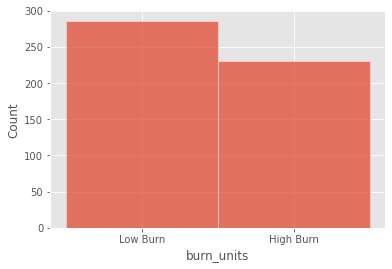

In [15]:
sns.histplot(data=df_cleaned, x='burn_units')

In [16]:
df_cleaned.tail(25)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_burned_area,burn_units
492,1,3,aug,fri,95.9,158.0,633.6,11.3,32.4,27,2.2,0.0,0.00,0.000000,Low Burn
493,1,3,aug,fri,95.9,158.0,633.6,11.3,27.5,29,4.5,0.0,43.32,3.791436,High Burn
494,6,6,aug,sat,96.0,164.0,643.0,14.0,30.8,30,4.9,0.0,8.59,2.260721,High Burn
495,6,6,aug,mon,96.2,175.5,661.8,16.8,23.9,42,2.2,0.0,0.00,0.000000,Low Burn
496,4,5,aug,mon,96.2,175.5,661.8,16.8,32.6,26,3.1,0.0,2.77,1.327075,High Burn
497,3,4,aug,tue,96.1,181.1,671.2,14.3,32.3,27,2.2,0.0,14.68,2.752386,High Burn
498,6,5,aug,tue,96.1,181.1,671.2,14.3,33.3,26,2.7,0.0,40.54,3.726657,High Burn
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82,2.469793,High Burn
500,8,6,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,0.000000,Low Burn
501,7,5,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,0.000000,Low Burn


## Where does most of the fire damage take place in this park?

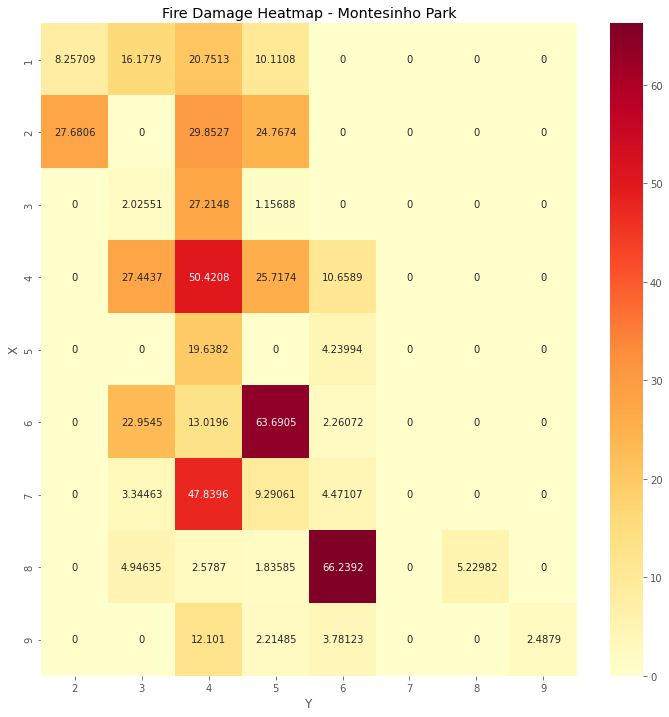

In [17]:
# Aggregate data to handle duplicate X, Y pairs (e.g., sum the burned areas)
df_agg = df_cleaned.groupby(['X', 'Y']).agg({'log_burned_area': 'sum'}).reset_index()

# Create a full grid for the park (assuming known X and Y ranges)
x_range = np.arange(df_agg['X'].min(), df_agg['X'].max() + 1)
y_range = np.arange(df_agg['Y'].min(), df_agg['Y'].max() + 1)
full_grid = pd.DataFrame([(x, y) for x in x_range for y in y_range], columns=['X', 'Y'])

# Merge the full grid with the aggregated data to fill in missing values
df_full = pd.merge(full_grid, df_agg, on=['X', 'Y'], how='left').fillna(0)

# Pivot the DataFrame to get X and Y as axes
heatmap_data = df_full.pivot('X', 'Y', 'log_burned_area')

# Generate the heatmap
plt.figure(figsize=(12,12))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g')

plt.title("Fire Damage Heatmap - Montesinho Park")
plt.show()

## What time of year do the most fires occur?

In [18]:
df_cleaned['month'].unique(), df_cleaned['day'].unique()

(array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
        'dec', 'may', 'nov'], dtype=object),
 array(['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu'], dtype=object))

In [19]:
# Map months and days to numerical values
month_order = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
               'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
day_order = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7}

# Convert the month and day columns to numerical values
df_cleaned['month_num'] = df_cleaned['month'].map(month_order)
df_cleaned['day_num'] = df_cleaned['day'].map(day_order)

# Sort the DataFrame by month and then by day
df_sorted = df_cleaned.sort_values(by=['month_num', 'day_num'])

df_cleaned = df_cleaned[['X', 'Y',
 'month', 'month_num',
 'day', 'day_num',
 'temp', 'wind', 'rain', 'RH', 
 'FFMC', 'DMC', 'DC', 'ISI',
 'area', 'log_burned_area', 'burn_units']].sort_values(by='month_num', ascending=True)

In [20]:
# Aggregate data to handle duplicate Month, Day pairs (e.g., sum the burned areas)
df_agg_time = df_sorted.groupby(['month', 'day'], sort=False).agg({'area': 'sum'}).reset_index()


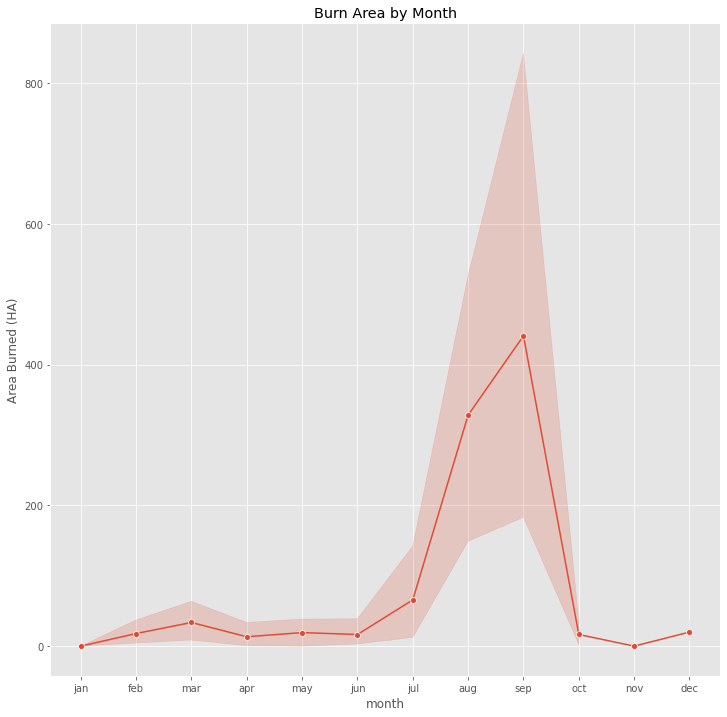

In [21]:
plt.figure(figsize=(12,12))

sns.lineplot(data=df_agg_time, x='month', y='area', marker='o', sort=False)

plt.title('Burn Area by Month')
plt.ylabel('Area Burned (HA)')
plt.show()

Summer time does really make sense. It also makes sense that it doesn't start until the end of the summer

## Were temperatures impacted by the location on the park?

(9.0, 0.0)

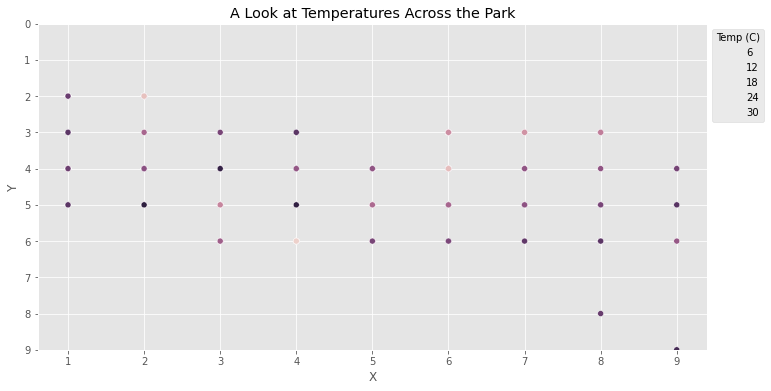

In [22]:
df_coords = df.sort_values(by=['X', 'Y'], ascending=False)
NY=df.Y.max()
NX=df.X.max()

plt.figure(figsize=(12,6))

g = sns.scatterplot(data=df_coords, x='X', y='Y', hue='temp')
plt.legend(title="Temp (C)")
plt.title("A Look at Temperatures Across the Park")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(NY,0)
# plt.xlim(NX,0)


## Was there any extreme drought concerns?

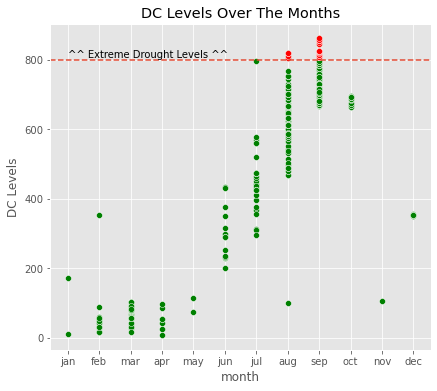

In [23]:
# Convert the month and day columns to numerical values
df['month_num'] = df['month'].map(month_order)
df['day_num'] = df['day'].map(day_order)

# Sort the DataFrame by month and then by day
df_dc = df.sort_values(by=['month_num', 'day_num'])


fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)

sns.scatterplot(x='month', y='DC', data=df_dc, ax=ax1, color='green')

sns.scatterplot(x='month', y='DC',
            data=df_dc[df_dc['DC'] >= 800], color='red', ax=ax1)

ax1.axhline(800, ls='--')
ax1.text(0,805, "^^ Extreme Drought Levels ^^")

plt.title('DC Levels Over The Months')
plt.ylabel('DC Levels')

plt.show()

In [24]:
df_cleaned

,X,Y,month,month_num,day,day_num,temp,wind,rain,RH,FFMC,DMC,DC,ISI,area,log_burned_area,burn_units
104,2,4,jan,1,sat,6,5.3,3.1,0.0,78,82.1,3.7,9.3,2.9,0.00,0.000000,Low Burn
379,4,5,jan,1,sun,7,5.2,0.9,0.0,100,18.7,1.1,171.4,0.0,0.00,0.000000,Low Burn
96,3,4,feb,2,sat,6,12.7,1.8,0.0,48,83.9,8.0,30.2,2.6,0.00,0.000000,Low Burn
59,2,2,feb,2,fri,5,12.3,0.9,0.0,51,86.6,13.2,43.0,5.3,0.00,0.000000,Low Burn
202,7,4,feb,2,sun,7,8.8,2.2,0.0,68,83.9,8.7,32.1,2.1,13.05,2.642622,High Burn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,8,6,dec,12,wed,3,5.1,8.0,0.0,61,84.0,27.8,354.6,5.3,11.19,2.500616,High Burn
281,6,5,dec,12,tue,2,5.1,8.5,0.0,24,85.4,25.4,349.7,2.6,24.77,3.249211,High Burn
273,4,6,dec,12,sun,7,4.8,8.5,0.0,57,84.4,27.2,353.5,6.8,8.98,2.300583,High Burn
279,4,4,dec,12,mon,1,4.6,8.5,0.0,21,85.4,25.4,349.7,2.6,9.77,2.376764,High Burn


## Inferential Analysis

H0: The time of year doesn't have any significant impact on the area burned.\
HA: The time of year will have a major impact on the area burned.

significance level of 95%\
alpha level = 0.50

In [25]:
from scipy.stats import f_oneway

alpha = 1 - .95


grouped_data = [df_cleaned[df_cleaned['month'] == month]['log_burned_area'] for month in df['month'].unique()]
anove_result = f_oneway(*grouped_data)
print(f'F-Statistic: {anove_result.statistic:.4f}')
print(f'P-value: {anove_result.pvalue:.4f}')

F-Statistic: 1.7654
P-value: 0.0572


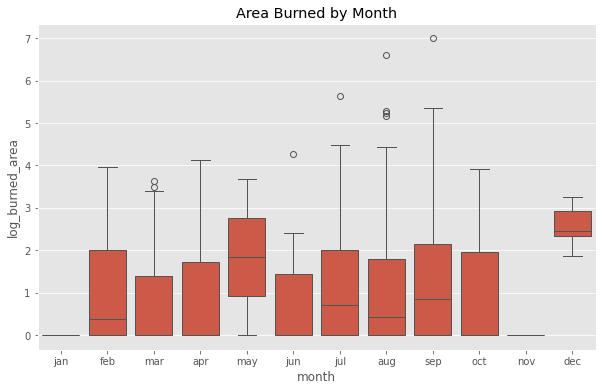

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='log_burned_area', data=df_cleaned)
plt.title('Area Burned by Month')
plt.show()

In [27]:
if anove_result.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


## A step into machine learning

,rain,temp,RH,wind,month_num,day_num,log_burned_area
rain,1.000000,0.069491,0.099751,0.061119,0.013438,-0.048340,0.023311
temp,0.069491,1.000000,-0.527390,-0.227116,0.368842,0.052190,0.053487
RH,0.099751,-0.527390,1.000000,0.069410,-0.095280,0.092151,-0.053662
wind,0.061119,-0.227116,0.069410,1.000000,-0.086368,0.032478,0.066973
month_num,0.013438,0.368842,-0.095280,-0.086368,1.000000,-0.050837,0.114280
day_num,-0.048340,0.052190,0.092151,0.032478,-0.050837,1.000000,0.000208
log_burned_area,0.023311,0.053487,-0.053662,0.066973,0.114280,0.000208,1.000000


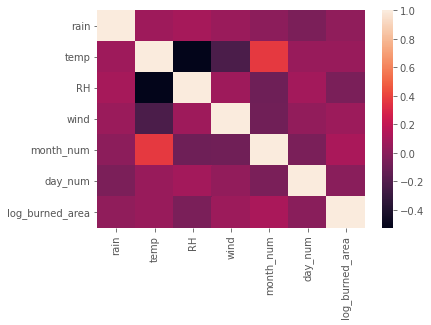

In [28]:
corr = df_cleaned[['rain','temp', 'RH', 'wind', 'month_num', 'day_num', 'log_burned_area']].corr()

sns.heatmap(corr)

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
            ]          

corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_caption("Hover to magify").set_table_styles(magnify())

<AxesSubplot:>

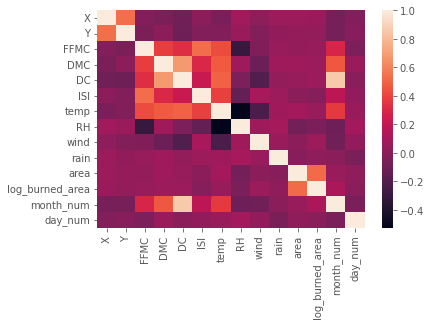

In [29]:
sns.heatmap(df.corr())

In [30]:
df_cleaned

,X,Y,month,month_num,day,day_num,temp,wind,rain,RH,FFMC,DMC,DC,ISI,area,log_burned_area,burn_units
104,2,4,jan,1,sat,6,5.3,3.1,0.0,78,82.1,3.7,9.3,2.9,0.00,0.000000,Low Burn
379,4,5,jan,1,sun,7,5.2,0.9,0.0,100,18.7,1.1,171.4,0.0,0.00,0.000000,Low Burn
96,3,4,feb,2,sat,6,12.7,1.8,0.0,48,83.9,8.0,30.2,2.6,0.00,0.000000,Low Burn
59,2,2,feb,2,fri,5,12.3,0.9,0.0,51,86.6,13.2,43.0,5.3,0.00,0.000000,Low Burn
202,7,4,feb,2,sun,7,8.8,2.2,0.0,68,83.9,8.7,32.1,2.1,13.05,2.642622,High Burn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,8,6,dec,12,wed,3,5.1,8.0,0.0,61,84.0,27.8,354.6,5.3,11.19,2.500616,High Burn
281,6,5,dec,12,tue,2,5.1,8.5,0.0,24,85.4,25.4,349.7,2.6,24.77,3.249211,High Burn
273,4,6,dec,12,sun,7,4.8,8.5,0.0,57,84.4,27.2,353.5,6.8,8.98,2.300583,High Burn
279,4,4,dec,12,mon,1,4.6,8.5,0.0,21,85.4,25.4,349.7,2.6,9.77,2.376764,High Burn


In [31]:
features = ['temp', 'RH', 'wind', 'DMC', 'DC']

X = df_cleaned.loc[:, features].values
y = df_cleaned.loc[:,['burn_units']].values

X = StandardScaler().fit_transform(X)


_____

Would a PCA approach work here?

In [32]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDF = pd.DataFrame(data = principalComponents, columns = ['principle component 1', 'principal component 2'])

principalDF

,principle component 1,principal component 2
0,3.732580,0.965832
1,3.416184,2.108635
2,2.325839,-0.899934
3,2.212568,-0.725944
4,3.035629,0.306752
...,...,...
512,3.220941,0.981077
513,2.785242,-0.795579
514,3.268442,0.824155
515,2.789921,-0.911675


In [33]:
df_final = pd.concat([principalDF, df_cleaned[['burn_units']]], axis = 1)

df_final

,principle component 1,principal component 2,burn_units
0,3.732580,0.965832,Low Burn
1,3.416184,2.108635,Low Burn
2,2.325839,-0.899934,Low Burn
3,2.212568,-0.725944,Low Burn
4,3.035629,0.306752,Low Burn
...,...,...,...
512,3.220941,0.981077,High Burn
513,2.785242,-0.795579,High Burn
514,3.268442,0.824155,High Burn
515,2.789921,-0.911675,Low Burn


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

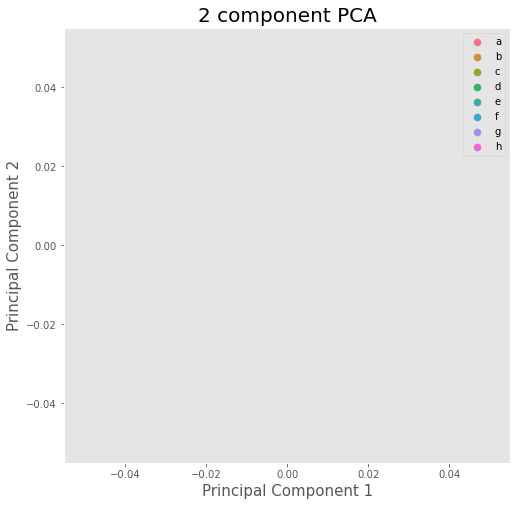

In [34]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['a', 'b', 'c', 'd', 'e', 'f', 'g','h']
colors = sns.color_palette("husl", 8)
for target, color in zip(targets,colors):
    indicesToKeep = df_final['burn_units'] == target
    ax.scatter(df_final.loc[indicesToKeep, 'principle component 1'], df_final.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [35]:
pca.explained_variance_ratio_

array([0.45002188, 0.25026433])

In [36]:
train_pca_X, test_pca_X, train_pca_y, test_pca_y = train_test_split (X, y, test_size=1/7.0, random_state=2)

In [37]:
scaler = StandardScaler()

scaler.fit(train_pca_X)

train_pca_X = scaler.transform(train_pca_X)
test_pca_X = scaler.transform(test_pca_X)

In [38]:
pca1 = PCA(.95)

In [39]:
pca1.fit(train_pca_X)

PCA(n_components=0.95)

In [40]:
train_X = pca1.transform(train_pca_X)
test_X = pca1.transform(test_pca_X)

In [41]:
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [42]:
logisticRegr.fit(train_pca_X, train_pca_y)

LogisticRegression()

In [43]:
logisticRegr.predict(test_pca_X[0].reshape(1,-1))

array(['Low Burn'], dtype=object)

In [44]:
logisticRegr.score(test_pca_X, test_pca_y)

0.5135135135135135

____

Let's Try and LDA approach

In [45]:
NUM_COMPONENTS = 1

In [46]:
X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(X, y, train_size=0.8, test_size = 0.2, random_state=42)

lda = LDA(n_components=NUM_COMPONENTS)

In [47]:
X_train_reduced_lda = lda.fit_transform(X_lda_train, y_lda_train)

In [48]:
X_test_reduced_lda = lda.transform(X_lda_test)

In [49]:
model_with_lda = KNN().fit(X_train_reduced_lda, y_lda_train)

y_pred = model_with_lda.predict(X_test_reduced_lda)

accuracy_score(y_true=y_lda_test, y_pred=y_pred)

0.6057692307692307

____

Let's give XGBoost a once over. 

In [50]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29, random_state=6)

#fit model no training data
model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
#make predictions for test data
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100.0:.2f}")


Accuracy: 52.67


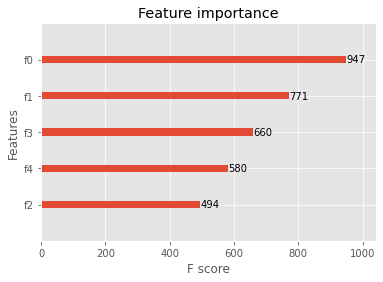

In [51]:
from xgboost import plot_importance

# plot feature importance
plot_importance(model)
plt.show()

In [52]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [value for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.165, n=5, Accuracy: 53.33%
Thresh=0.183, n=4, Accuracy: 52.00%
Thresh=0.196, n=3, Accuracy: 50.00%
Thresh=0.221, n=2, Accuracy: 52.00%
Thresh=0.235, n=1, Accuracy: 50.67%
